In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import gspread
from gspread_dataframe import get_as_dataframe, set_with_dataframe
import sys
import os
from oauth2client.service_account import ServiceAccountCredentials
from dotenv import load_dotenv

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 500

import warnings
warnings.filterwarnings("ignore")

import matplotlib.font_manager as fm
font_path = './Pretendard-Regular.ttf'
font_name = fm.FontProperties(fname=font_path).get_name()
plt.rc('font', family=font_name)

In [2]:
def resource_path(relative_path):
    if hasattr(sys, '_MEIPASS'):
        return os.path.join(sys._MEIPASS, relative_path)
    return os.path.join(os.path.abspath("."), relative_path)

def get_spreadsheet(sheet_name):
    scope = [
    'https://spreadsheets.google.com/feeds',
    'https://www.googleapis.com/auth/drive',
    ]

    json_file_name = 'ssu-intl-community-8ccf0b472aad.json'

    credentials = ServiceAccountCredentials.from_json_keyfile_name(resource_path(json_file_name), scope)
    gc = gspread.authorize(credentials)

    doc = gc.open(sheet_name)
    return doc

In [3]:
doc = get_spreadsheet('교환학생 DB')

In [4]:
work_sheet = doc.worksheet('파견가능대학')
uni_list = get_as_dataframe(work_sheet)

uni_list.dropna(axis=0, how='all', inplace=True)
uni_list.dropna(axis=1, how='all', inplace=True)

In [5]:
uni_list['파견종류'].replace('교환학생\n +인턴십', '교환학생+인턴십', inplace=True)
uni_list['파견종류'].replace('순수', '일반교환', inplace=True)
uni_list['파견종류'].replace('방문', '방문교환', inplace=True)
uni_list['파견종류'].replace('특별', '방문교환', inplace=True)

In [6]:
uni_count_result = uni_list.groupby(['파견학기', '모집차수'], as_index=False).count()[['파견학기', '모집차수', '일련번호']]
uni_count_result = uni_count_result.rename(columns={'일련번호': '파견가능 학교'})
target_sheet = doc.worksheet('파견가능 학교')
set_with_dataframe(target_sheet, uni_count_result)

(0.0, 500.0)

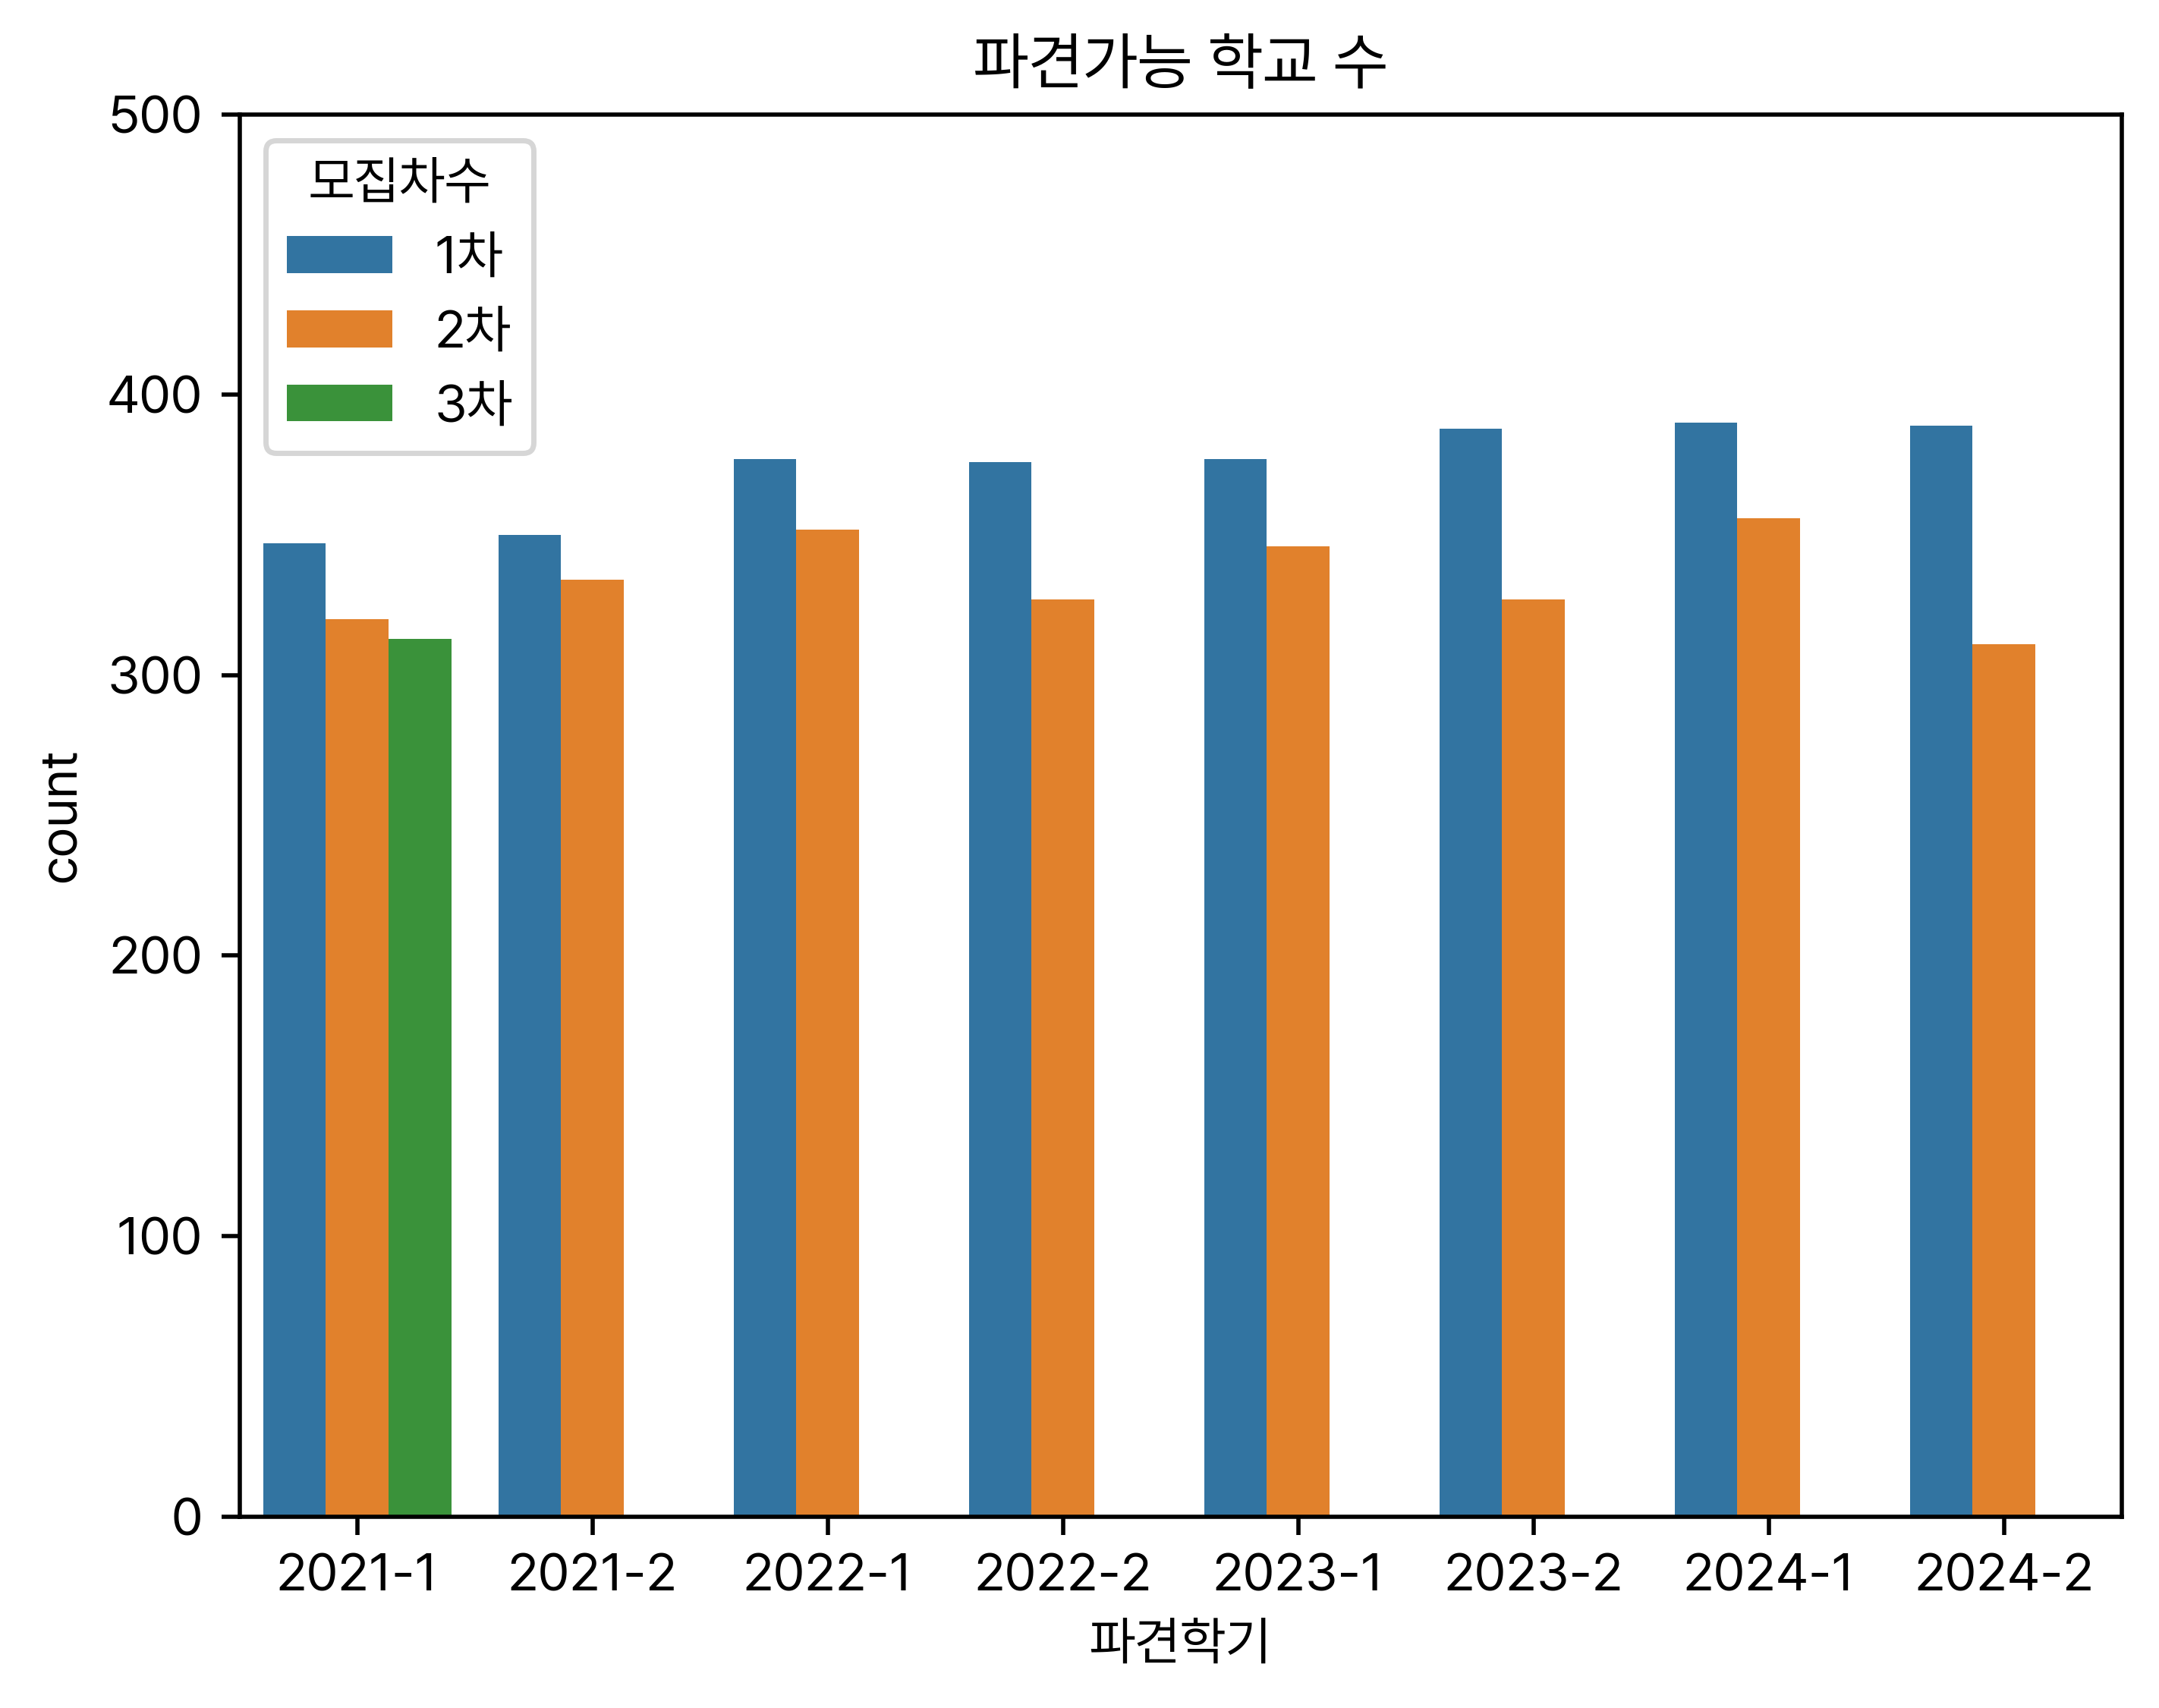

In [7]:
uni_count_viz = uni_list.groupby(['파견학기', '모집차수'], as_index=False).count()[['파견학기', '모집차수', '일련번호']]
sns.barplot(x='파견학기', y='일련번호', hue='모집차수', data=uni_count_viz)
plt.title('파견가능 학교 수')
plt.ylabel('count')
plt.ylim(0, 500)

(0.0, 400.0)

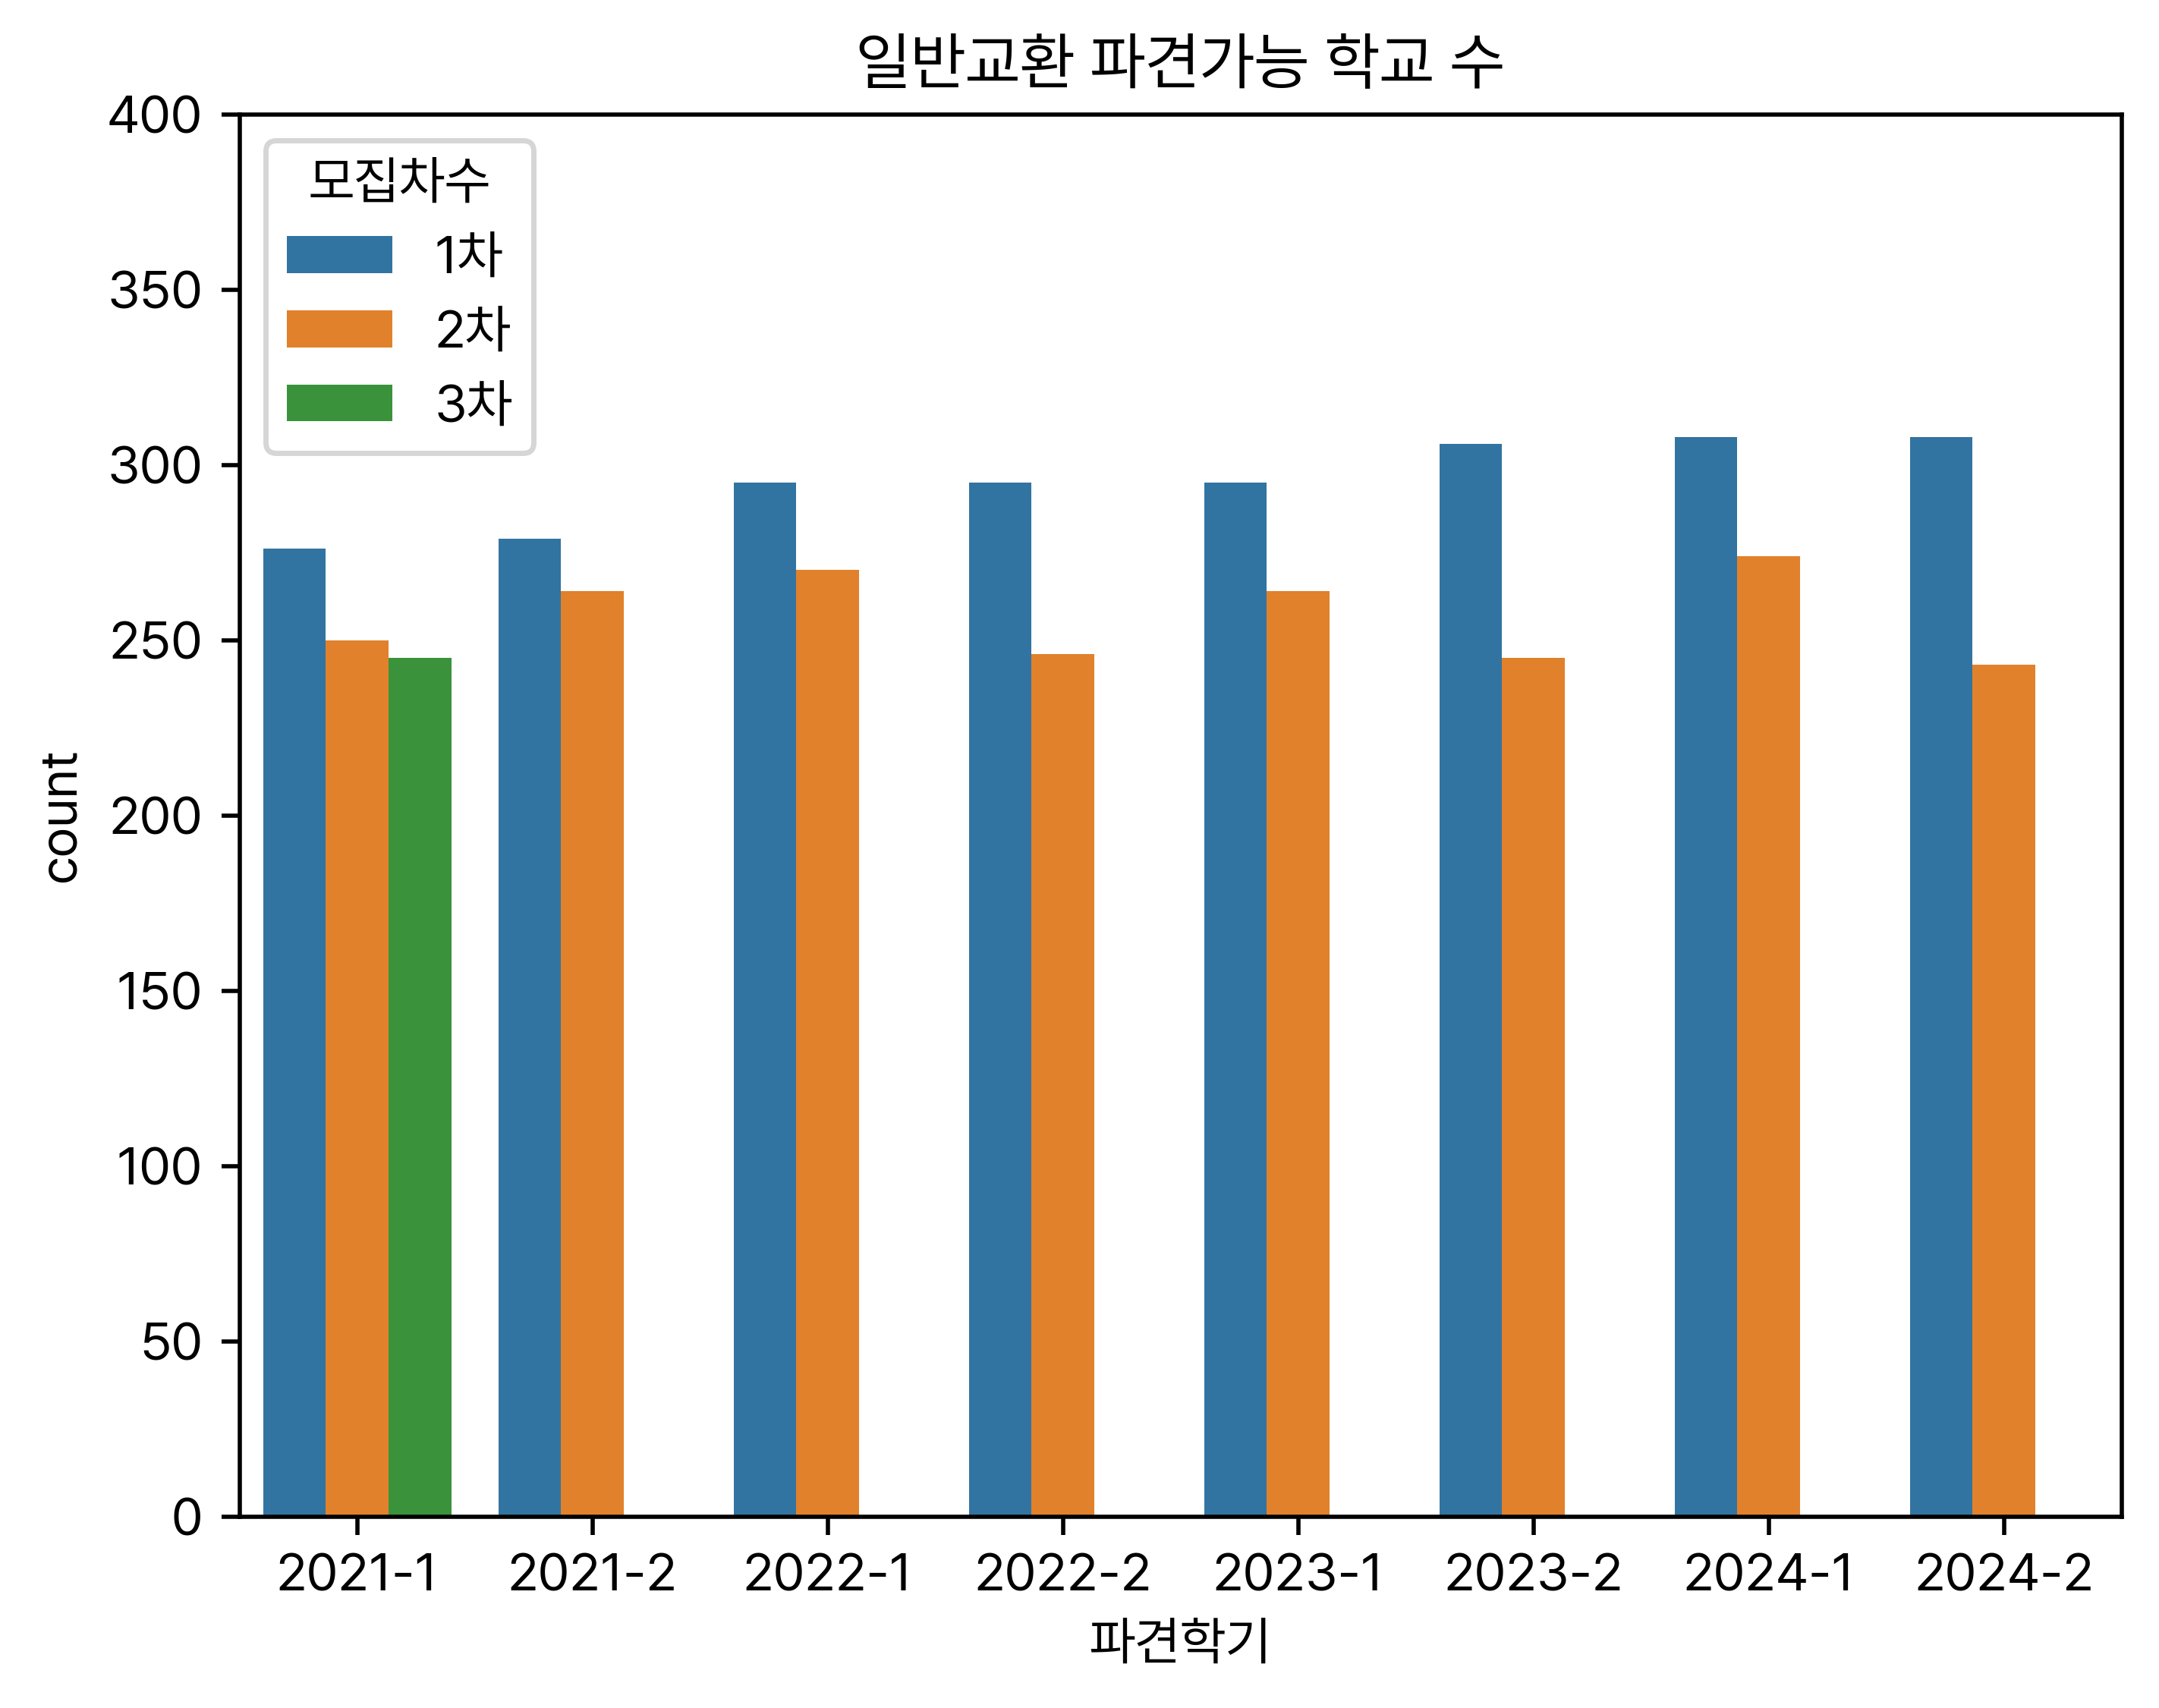

In [8]:
uni_count_viz = uni_list[uni_list['파견종류'] == '일반교환'].groupby(['파견학기', '모집차수'], as_index=False).count()[['파견학기', '모집차수', '일련번호']]
sns.barplot(x='파견학기', y='일련번호', hue='모집차수', data=uni_count_viz)
plt.title('일반교환 파견가능 학교 수')
plt.ylabel('count')
plt.ylim(0, 400)

In [10]:
sem_list = uni_list['파견학기'].unique()
normal_uni_list = uni_list[uni_list['파견종류'] == '일반교환']
pop_uni_list = normal_uni_list.iloc[:0].copy()
for s in sem_list:
    pop_uni_list = pd.concat([pop_uni_list, normal_uni_list[normal_uni_list['파견학기'] == s][normal_uni_list['모집차수'] == '1차'][~normal_uni_list['대학명 (국문)'].isin(normal_uni_list[normal_uni_list['파견학기'] == s][normal_uni_list['모집차수'] == '2차']['대학명 (국문)'].unique())]])

pop_uni_list = pop_uni_list[['국가', '대학명 (국문)', '대학명 (영문)']]
pop_uni_list.drop_duplicates(subset=['대학명 (국문)'], inplace=True)
pop_uni_list.sort_values(by=['국가', '대학명 (국문)'], inplace=True)
target_sheet = doc.worksheet('인기학교_1')
set_with_dataframe(target_sheet, pop_uni_list)

In [11]:
work_sheet = doc.worksheet('예비합격자')
result_list = get_as_dataframe(work_sheet)

result_list.dropna(axis=0, how='all', inplace=True)
result_list.dropna(axis=1, how='all', inplace=True)

In [12]:
result = result_list.groupby(['파견학기', '모집차수'], as_index=False).count()[['파견학기', '모집차수', '대학']]
result = result.rename(columns={'대학': '에비합격자'})
target_sheet = doc.worksheet('학기 당 파견자')
set_with_dataframe(target_sheet, result)

Text(0, 0.5, 'count')

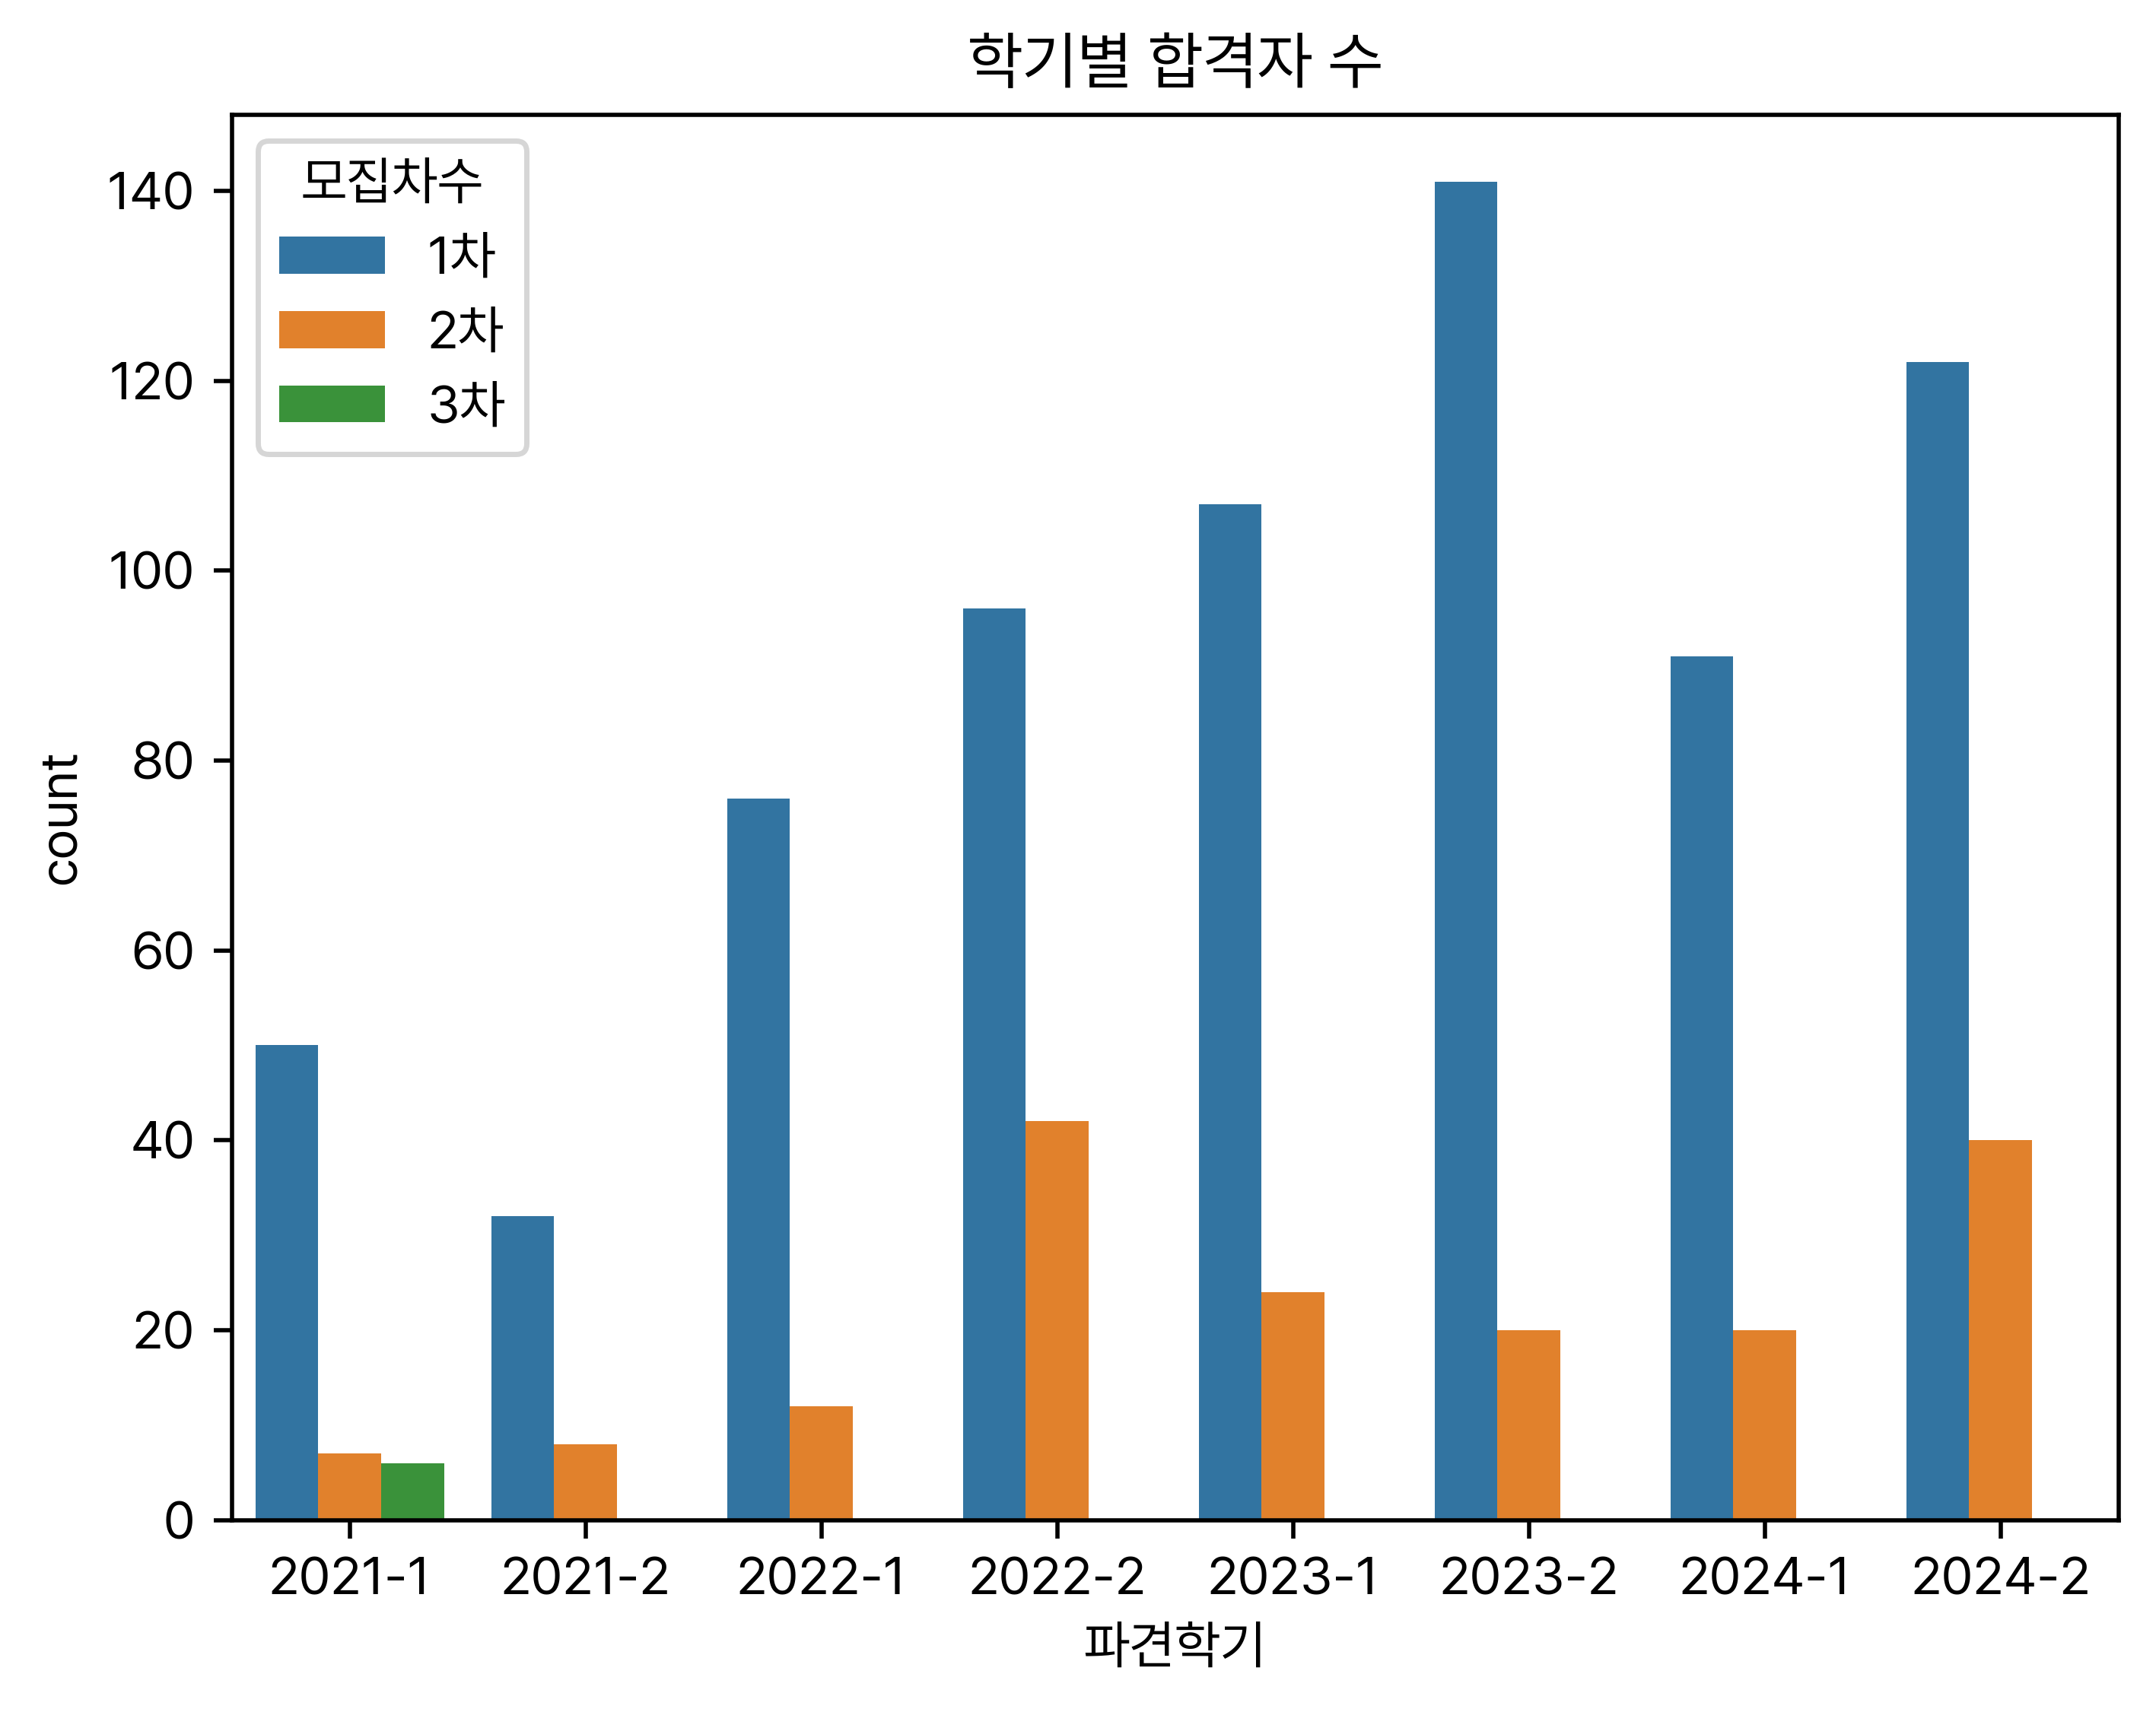

In [13]:
sns.barplot(x='파견학기', y='에비합격자', hue='모집차수', data=result)
plt.title('학기별 합격자 수')
plt.ylabel('count')

In [14]:
scholarship_list = result_list[~result_list['장학'].isna()][['파견학기', '모집차수', '국가', '대학', '장학']]
target_sheet = doc.worksheet('장학')
set_with_dataframe(target_sheet, scholarship_list)